# Example: Mixing Layer

In this example, a custom flow is created and demonstrated.

In [1]:
from typing import Union, List, Optional

import torch

import lettuce as lt
import matplotlib.pyplot as plt
import numpy as np

from lettuce import UnitConversion

## Setup

In [2]:
def randu(nx, ny, nz):
    # returns values between -1 and 1
    return (np.random.rand(nx, ny, nz)-0.5)*2


class MixingLayer(lt.ExtFlow):

    def __init__(self, context: lt.Context, resolution, reynolds_number,
                 mach_number, stencil: 'Stencil'):
        self.stencil = stencil
        self.d = stencil.d
        super().__init__(context, resolution, reynolds_number, mach_number,
                         stencil=stencil)
        self._mask = torch.zeros(self.resolution, dtype=torch.bool)

    def make_resolution(self, resolution: Union[int, List[int]],
                        stencil: Optional['Stencil'] = None) -> List[int]:
        if isinstance(resolution, int):
            assert stencil is not None, "stencil must be provided if resolution is an integer"
            return [resolution] * stencil.d
        else:
            assert len(resolution) in [2, 3], ('the resolution of the mixing'
                                               ' layer must be 2- or 3-dimensional!')

    def make_units(self, reynolds_number, mach_number,
                   resolution: List[int]) -> 'UnitConversion':
        return UnitConversion(reynolds_number=reynolds_number, mach_number=mach_number,
                 characteristic_length_pu=resolution[0])

    def initial_pu(self):
        x = self.context.convert_to_ndarray(self.grid[0])
        y = self.context.convert_to_ndarray(self.grid[1])
        p = np.array([0 * x], dtype=float)
        nx, ny, *nz = self.resolution
        nz = nz[0] if nz else 1
        shearlayerthickness = 0.093
        amplitude = 1
        centering = (np.exp(
            -pow(
                y/(2*shearlayerthickness),
                2)
        ) * amplitude)
        u = []
        for dim in range(len(self.grid)):
            u.append(randu(nx, ny, nz) * centering)
            u[dim] = u[dim][..., 0] if self.d == 2 else u[dim]
        u[0] = np.tanh(y/(2*shearlayerthickness))
        u = np.array(u, dtype=float)
        return p, u

    @property
    def mask(self):
        return self._mask

    @property
    def grid(self):
        xyz = tuple(torch.linspace(-1, 1, steps=n) for n in self.resolution)
        return torch.meshgrid(*xyz, indexing='ij')

    @property
    def boundaries(self):
        x, y, *z = self.grid
        top = np.zeros(np.shape(y), dtype=bool)
        bottom = np.zeros(np.shape(y), dtype=bool)
        bottom[:, 0] = True  # bottom
        top[:, -1] = True  # top
        downstream = np.array([1.0, 0.0, 0.0]) if len(self.grid) == 3\
            else np.array([1.0, 0.0])
        return [
            # moving fluid on top and bottom
            lt.EquilibriumBoundaryPU(self.context, top, downstream),
            lt.EquilibriumBoundaryPU(self.context, bottom, -downstream),
        ]

context = lt.Context()
flow = MixingLayer(context=context, resolution=256, reynolds_number=10000,
                   mach_number=0.05, stencil=lt.D2Q9())
collision = lt.BGKCollision(tau=flow.units.relaxation_parameter_lu)
simulation = lt.Simulation(flow=flow, collision=collision, reporter=[])
energyspectrum = lt.EnergySpectrum(flow)
reporter = lt.ObservableReporter(energyspectrum, interval=500, out=None)
simulation.reporter.append(reporter)

steps     time     EnergySpectrum


### Initialized flow

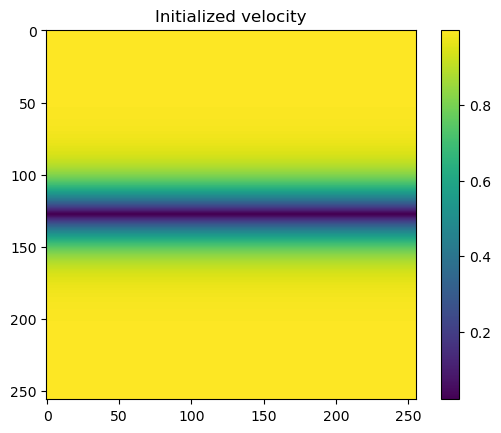

In [3]:
u = context.convert_to_ndarray(flow.u_pu)
u_norm = np.linalg.norm(u,axis=0)
plt.imshow(u_norm.transpose())
plt.colorbar()
plt.title('Initialized velocity')
plt.show()

## Run simulation

In [4]:
mlups = simulation(num_steps=2000)
print("Performance in MLUPS:", mlups)

Performance in MLUPS: 102.13895947138577


### Velocity
* Velocity field after the simulation

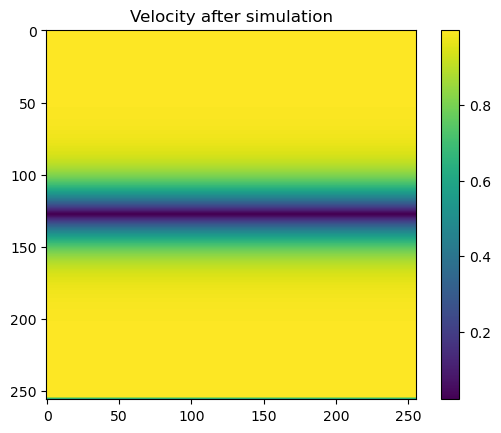

In [5]:
u = context.convert_to_ndarray(flow.u_pu)
u_norm = np.linalg.norm(u,axis=0)
plt.imshow(u_norm.transpose())
plt.colorbar()
plt.title('Velocity after simulation')
plt.show()

### Vorticity
* Vorticity field after the simulation

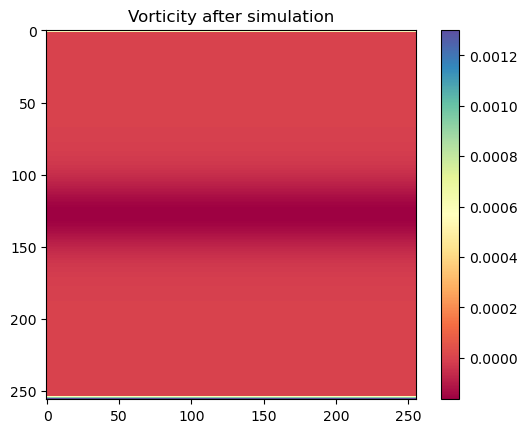

In [6]:
dx = flow.units.convert_length_to_pu(1.0)
grad_u0 = np.gradient(u[0], dx)
grad_u1 = np.gradient(u[1], dx)
vorticity = (grad_u1[0] - grad_u0[1])
plt.imshow(vorticity.transpose(), cmap='Spectral')
plt.colorbar()
plt.title('Vorticity after simulation')
plt.show()